# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 101 GB / percent used: 19.8 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(0,60)
lonlim=(30,140)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Near-Surface Air Temperature

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'tas'
table = 'Amon'

# Load historical
tas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]-273.15

# ERA-Interim
tas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()-273.15

## Regrid

In [4]:
regridder = xe.Regridder(tas_era, tas, 'bilinear', periodic=True, reuse_weights=True)
tas_era_regrid = regridder(tas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Select zone

In [5]:
tas = tas.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
tas_era_regrid = tas_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Compute clim

In [6]:
tas_clim = tas.mean('time')
tas_era_regrid_clim = tas_era_regrid.mean('time')

In [7]:
tas_bias = tas_clim-tas_era_regrid_clim

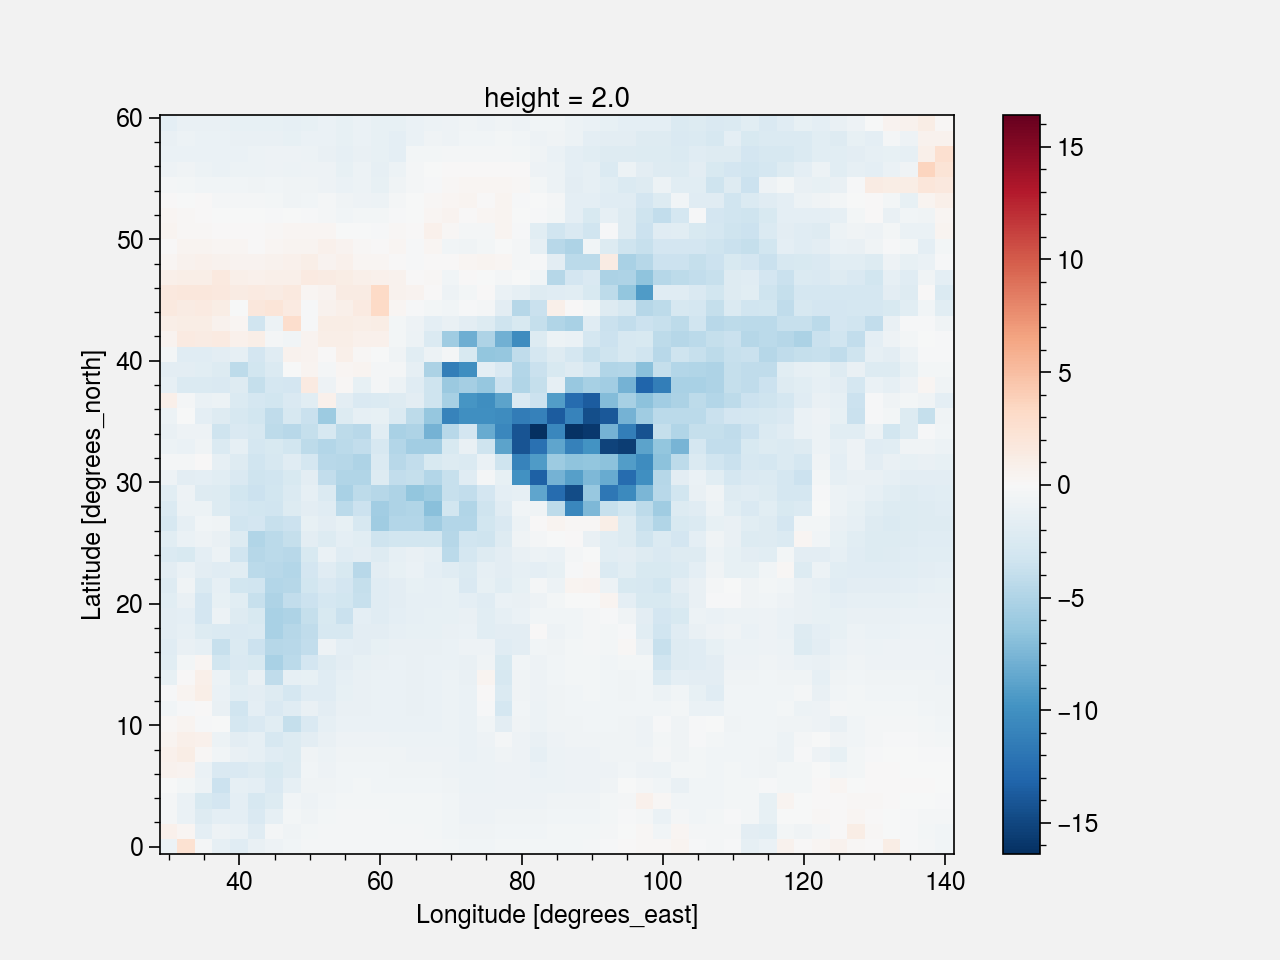

In [8]:
tas_bias.plot()

In [9]:
tas_bias.max()

<xarray.DataArray ()>
array(3.66749612)
Coordinates:
    height   float64 2.0

In [10]:
tas_bias.min()

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    height   float64 2.0

In [11]:
tas.lon.values

array([ 30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,
        52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5,  80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,
        97.5, 100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
       120. , 122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5, 140. ],
      dtype=float32)

In [12]:
tas.lat.values

array([ 0.       ,  1.2676057,  2.5352113,  3.8028169,  5.0704226,
        6.338028 ,  7.6056337,  8.8732395, 10.140845 , 11.408451 ,
       12.676056 , 13.943662 , 15.211267 , 16.478872 , 17.746479 ,
       19.014084 , 20.28169  , 21.549295 , 22.816902 , 24.084507 ,
       25.352112 , 26.619719 , 27.887323 , 29.15493  , 30.422535 ,
       31.690142 , 32.957745 , 34.225353 , 35.492958 , 36.760563 ,
       38.028168 , 39.295776 , 40.56338  , 41.830986 , 43.09859  ,
       44.366196 , 45.633804 , 46.90141  , 48.169014 , 49.43662  ,
       50.704224 , 51.971832 , 53.239437 , 54.507042 , 55.774647 ,
       57.042255 , 58.30986  , 59.577465 ], dtype=float32)

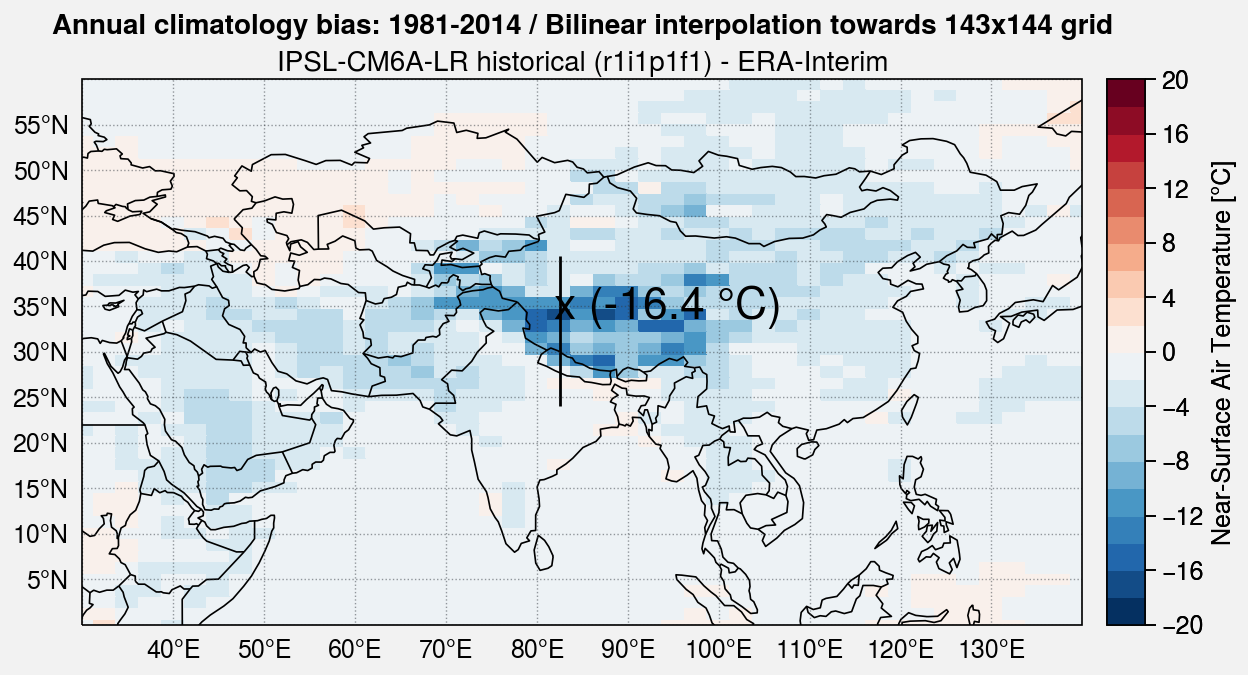

In [55]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(tas_bias, cmap='RdBu_r', levels=plot.arange(-20,20,2))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Near-Surface Air Temperature [°C]')

# Add boxes
# for ax in axs:
#     u.plot_zones_IPSL_CM6A_LR(ax)
    
axs[0].add_patch(mpatches.Rectangle(
    xy=[82.5, 24.084507], width=0, height=40.56338-24.084507,
    transform=ccrs.PlateCarree(), fill=False
))
axs[0].text(82.5-dx/4, 34.225353-dy/2, 'x (-16.4 °C)', fontsize=16, 
#             horizontalalignment='center', verticalalignment='center'
           )

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=5, abc=False, latlim=latlim, lonlim=lonlim
)

var = 'ta'
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_ext.png')
# f.save('img/'+var+'/tas_IPSL_CMIP6-ERAI_bias_ext.pdf')

In [14]:
tas_bias.sel(lat=34.225353, lon=82.5)

<xarray.DataArray ()>
array(-16.39639211)
Coordinates:
    lat      float32 34.225353
    lon      float32 82.5
    height   float64 2.0

In [15]:
tas_bias.sel(lat=30.422535, lon=82.5)

<xarray.DataArray ()>
array(-13.37309474)
Coordinates:
    lat      float32 30.422535
    lon      float32 82.5
    height   float64 2.0

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [16]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [17]:
ps_era_regrid = regridder(ps_era)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_era_regrid = ps_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Air Temperature

In [18]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

ta_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/ta.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).ta.sel(time=period).load()-273.15

## Regrid horizontal

In [19]:
# Regrid horizontal
ta_era_regrid = regridder(ta_era)

## Select zone

In [20]:
ta = ta.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ta_era_regrid = ta_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Mask vertical values > ps

In [21]:
ta_era_regrid_masked = ta_era_regrid.where(ta_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [22]:
ta_era_regrid_masked_v = ta_era_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [23]:
ta_clim = ta.mean('time', skipna=False).load()
ta_era_regrid_masked_clim = ta_era_regrid_masked.mean('time', skipna=False).load()
ta_era_regrid_masked_v_clim = ta_era_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_clim-ta_era_regrid_masked_v_clim.values

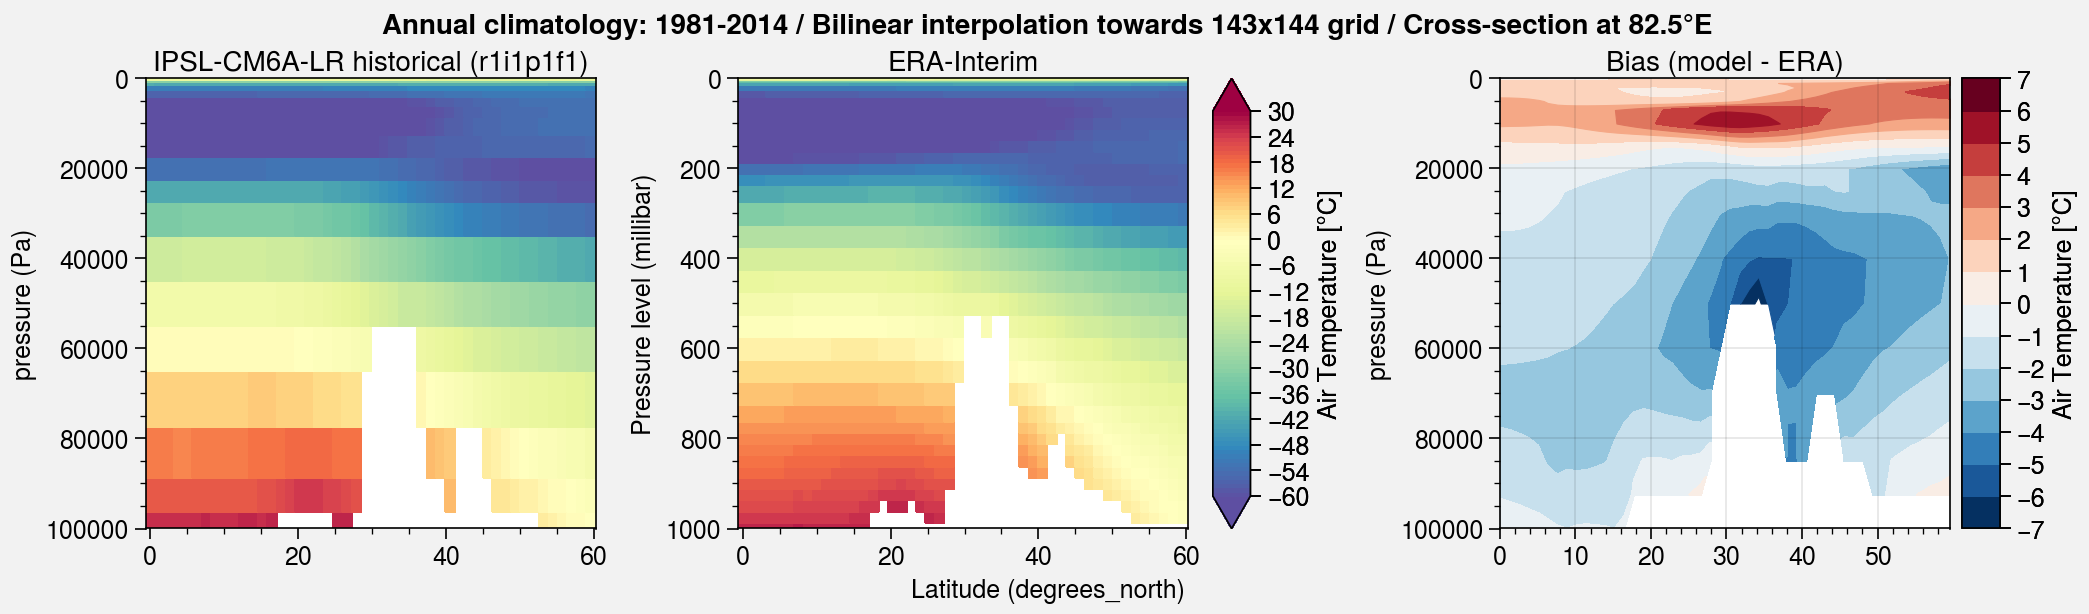

In [56]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_ext.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_ext.pdf')

In [25]:
ta_bias.lat

<xarray.DataArray 'lat' (lat: 48)>
array([ 0.      ,  1.267606,  2.535211,  3.802817,  5.070423,  6.338028,
        7.605634,  8.87324 , 10.140845, 11.408451, 12.676056, 13.943662,
       15.211267, 16.478872, 17.746479, 19.014084, 20.28169 , 21.549295,
       22.816902, 24.084507, 25.352112, 26.619719, 27.887323, 29.15493 ,
       30.422535, 31.690142, 32.957745, 34.225353, 35.492958, 36.760563,
       38.028168, 39.295776, 40.56338 , 41.830986, 43.09859 , 44.366196,
       45.633804, 46.90141 , 48.169014, 49.43662 , 50.704224, 51.971832,
       53.239437, 54.507042, 55.774647, 57.042255, 58.30986 , 59.577465],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
Attributes:
    axis:           Y
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

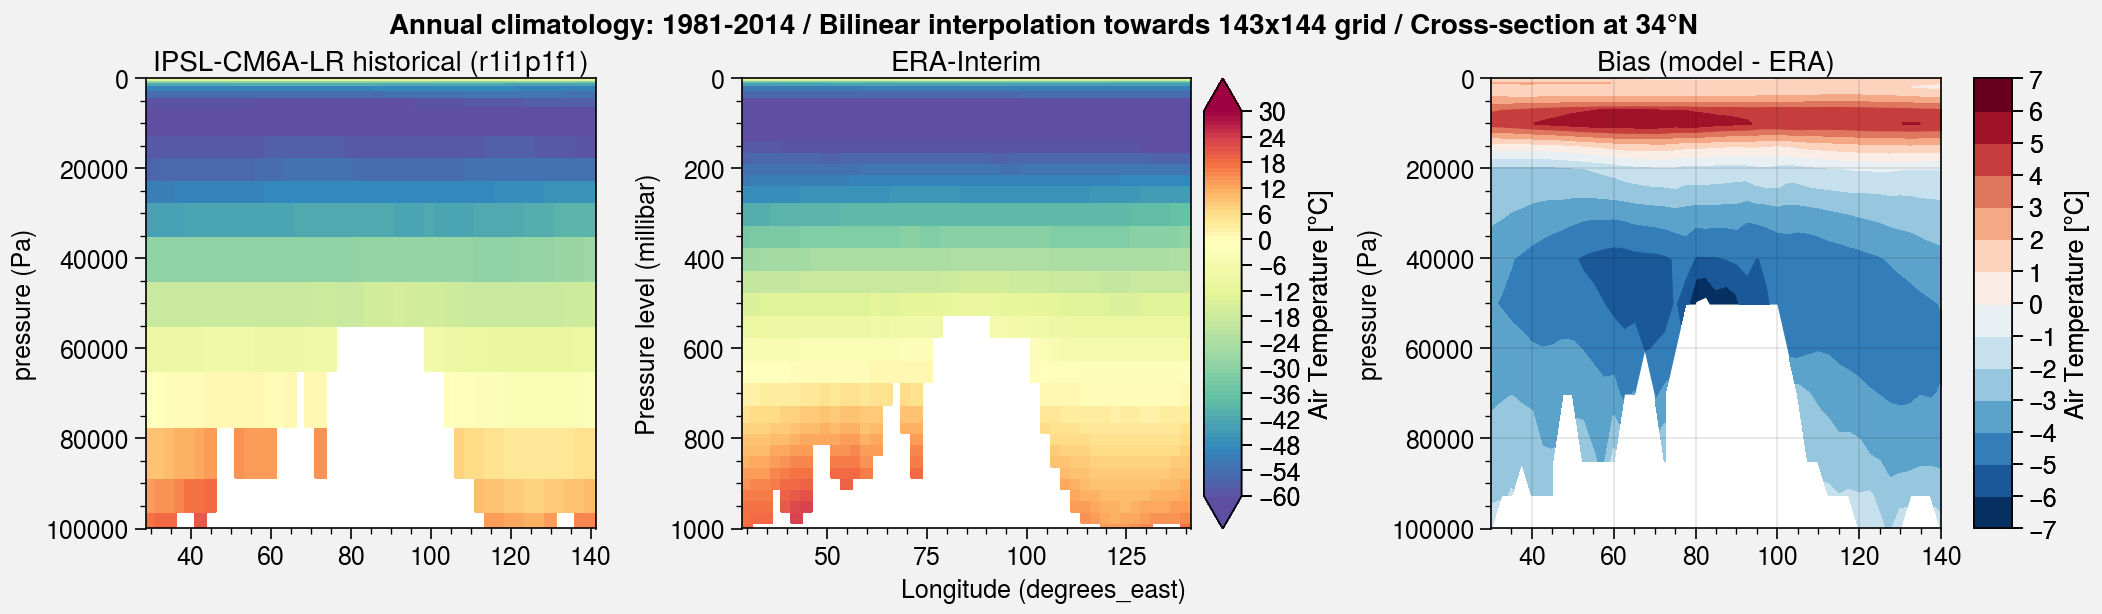

In [57]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_ext.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_ext.pdf')

## Differences

In [29]:
ta_bias.max()

<xarray.DataArray 'ta' ()>
array(6.11707188)

In [30]:
ta_bias.min()

<xarray.DataArray 'ta' ()>
array(-7.34939633)

In [31]:
str(ta_bias.isel(lon=0).lon.values)

'30.0'

In [84]:
21/4

5.25

In [33]:
ta_bias.lon

<xarray.DataArray 'lon' (lon: 45)>
array([ 30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,  52.5,
        55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
        80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. , 102.5,
       105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5,
       130. , 132.5, 135. , 137.5, 140. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 30.0 32.5 35.0 37.5 40.0 ... 132.5 135.0 137.5 140.0
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [38]:
ta_bias.lon[0:-1:2]

<xarray.DataArray 'lon' (lon: 22)>
array([ 30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,  75.,  80.,  85.,
        90.,  95., 100., 105., 110., 115., 120., 125., 130., 135.],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 30.0 35.0 40.0 45.0 50.0 ... 120.0 125.0 130.0 135.0
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [32]:
for i in range(20):
    ta_bias.lon[i]

<xarray.DataArray 'lon' (lon: 45)>
array([ 30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,  52.5,
        55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
        80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5, 100. , 102.5,
       105. , 107.5, 110. , 112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5,
       130. , 132.5, 135. , 137.5, 140. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 30.0 32.5 35.0 37.5 40.0 ... 132.5 135.0 137.5 140.0
Attributes:
    axis:           X
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [40]:
ta_bias

<xarray.DataArray 'ta' (plev: 19, lat: 48, lon: 45)>
array([[[        nan,         nan,         nan, ..., -0.48241948,
         -0.51775757, -0.60054293],
        [        nan,         nan,         nan, ..., -0.43961878,
         -0.50238424, -0.5769318 ],
        [        nan,         nan,         nan, ..., -0.35198484,
         -0.3874352 , -0.41318565],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -1.66272743,
         -1.68574305, -1.76089735],
        [        nan,         nan,         nan, ..., -1.52258874,
         -1.58681184, -1.66477301],
        [        nan,         nan,         nan, ..., -1.34438439,
         -1.40849735, -1.44766871],
        ...,
        [-0.62543686, -0.59126138, -0.62714788, ..., -0.7503662 ,
          1.21775583,  1.08823736],
        [-0.72040774, -0.69642739, -0.64125685, ...,  0.60142864,
          1.6248369 ,  1.36528684],
        [-0.79927342, -0.75825262, -0.63203513, ...,  1.87174764,
                 nan,         nan]],

       [[-0.12760069,  0.84286973,         nan, ..., -1.68315031,
         -1.78248894, -1.78764612],
        [ 0.22256206,  0.36903057,         nan, ..., -1.67495112,
         -1.73664509, -1.78362541],
        [ 0.14244985, -0.41202685, -1.21451768, ..., -1.6359752 ,
         -1.68919543, -1.72245911],
        ...,
        [-1.14346123, -1.05964526, -1.0377812 , ...,  0.9638161 ,
          0.82706579,  0.21373562],
        [-1.24564519, -1.15747056, -1.08622873, ...,  0.81556601,
          1.03280661,  0.25023786],
        [-1.30674223, -1.2171052 , -1.10546703, ...,  1.11311597,
          1.06224441,  0.25433086]],

       ...,

       [[ 1.66946621,  1.67163972,  1.69364693, ...,  1.9002978 ,
          1.89595735,  1.89460151],
        [ 1.66282274,  1.67314127,  1.68942773, ...,  1.87880966,
          1.88194235,  1.89126225],
        [ 1.64676985,  1.66133355,  1.67128542, ...,  1.85143038,
          1.86317294,  1.87266668],
        ...,
        [ 4.74650774,  4.7172941 ,  4.68612912, ...,  1.01446705,
          0.91589666,  0.85054597],
        [ 4.96531686,  4.93862082,  4.90537843, ...,  1.07486004,
          1.00435746,  0.91147406],
        [ 5.17602627,  5.15286616,  5.12024873, ...,  1.16937819,
          1.08104575,  1.00934542]],

       [[ 0.81944499,  0.80847473,  0.80305848, ...,  0.9748399 ,
          0.95995964,  0.94517344],
        [ 0.8392593 ,  0.82974205,  0.82637669, ...,  0.99119401,
          0.97744647,  0.96428015],
        [ 0.86455495,  0.85837301,  0.85901296, ...,  1.00918645,
          0.99514823,  0.9900178 ],
        ...,
        [ 5.23469645,  5.13470306,  5.03276113, ..., -0.63501062,
         -0.74058423, -0.7905328 ],
        [ 5.56301345,  5.45484741,  5.35222586, ..., -0.59884085,
         -0.66961493, -0.76576355],
        [ 5.89139482,  5.77983792,  5.67136863, ..., -0.50837531,
         -0.60571014, -0.67893708]],

       [[-2.25083222, -2.2729457 , -2.29389708, ..., -2.28304968,
         -2.31895246, -2.3445336 ],
        [-2.23766742, -2.25557403, -2.27597737, ..., -2.27900576,
         -2.31399208, -2.3443126 ],
        [-2.20671433, -2.22260482, -2.24201171, ..., -2.25947278,
         -2.29203658, -2.32497066],
        ...,
        [ 1.78158118,  1.63148489,  1.47666497, ..., -1.19864478,
         -1.17437263, -1.07683218],
        [ 1.93855509,  1.7808251 ,  1.62098542, ..., -1.41861917,
         -1.33392487, -1.30227089],
        [ 2.06059434,  1.90177484,  1.73636021, ..., -1.59042642,
         -1.54518806, -1.46939728]]])
Coordinates:
  * lat      (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
  * lon      (lon) float32 30.0 32.5 35.0 37.5 40.0 ... 132.5 135.0 137.5 140.0
  * p

In [50]:
ta_bias[:,:,0:-1:2]

<xarray.DataArray 'ta' (plev: 19, lat: 48, lon: 22)>
array([[[        nan,         nan,         nan, ...,  0.31458182,
          0.35628474, -0.48241948],
        [        nan,         nan,         nan, ...,         nan,
         -0.01690793, -0.43961878],
        [        nan,         nan,         nan, ...,  0.00971097,
         -0.08860593, -0.35198484],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan, -1.13094604, ..., -0.81412407,
         -0.87881809, -1.66272743],
        [        nan,         nan, -1.06998946, ..., -0.78361378,
         -1.13225443, -1.52258874],
        [        nan,         nan, -0.82376322, ..., -0.94714026,
         -1.12268556, -1.34438439],
        ...,
        [-0.62543686, -0.62714788, -0.62851788, ...,         nan,
                 nan, -0.7503662 ],
        [-0.72040774, -0.64125685, -0.64763382, ...,         nan,
         -1.71947677,  0.60142864],
        [-0.79927342, -0.63203513, -0.63173596, ...,  0.07594271,
          0.76828311,  1.87174764]],

       [[-0.12760069,         nan, -1.53108495, ..., -1.32703595,
         -1.42872351, -1.68315031],
        [ 0.22256206,         nan, -1.44683108, ..., -1.42010204,
         -1.43182644, -1.67495112],
        [ 0.14244985, -1.21451768, -1.32761167, ..., -1.44353271,
         -1.44678612, -1.6359752 ],
        ...,
        [-1.14346123, -1.0377812 , -1.06052155, ..., -0.22607088,
         -0.21841083,  0.9638161 ],
        [-1.24564519, -1.08622873, -1.07595865, ..., -0.0958622 ,
          0.52473191,  0.81556601],
        [-1.30674223, -1.10546703, -1.0668234 , ...,  0.17870862,
          0.7611236 ,  1.11311597]],

       ...,

       [[ 1.66946621,  1.69364693,  1.71656386, ...,  1.87742603,
          1.90029793,  1.9002978 ],
        [ 1.66282274,  1.68942773,  1.70997766, ...,  1.86246709,
          1.88560217,  1.87880966],
        [ 1.64676985,  1.67128542,  1.68980661, ...,  1.84073916,
          1.8591273 ,  1.85143038],
        ...,
        [ 4.74650774,  4.68612912,  4.60001136, ...,  1.44941159,
          1.22024574,  1.01446705],
        [ 4.96531686,  4.90537843,  4.81184355, ...,  1.52056812,
          1.28638481,  1.07486004],
        [ 5.17602627,  5.12024873,  5.02365063, ...,  1.62185545,
          1.38392605,  1.16937819]],

       [[ 0.81944499,  0.80305848,  0.79868291, ...,  1.01583945,
          0.99524277,  0.9748399 ],
        [ 0.8392593 ,  0.82637669,  0.82360826, ...,  1.03402637,
          1.01234017,  0.99119401],
        [ 0.86455495,  0.85901296,  0.85350073, ...,  1.05823251,
          1.03720255,  1.00918645],
        ...,
        [ 5.23469645,  5.03276113,  4.82345571, ..., -0.27184499,
         -0.45854178, -0.63501062],
        [ 5.56301345,  5.35222586,  5.14780428, ..., -0.21641455,
         -0.41343883, -0.59884085],
        [ 5.89139482,  5.67136863,  5.46629413, ..., -0.10683116,
         -0.31982486, -0.50837531]],

       [[-2.25083222, -2.29389708, -2.35708638, ..., -2.25238982,
         -2.22477008, -2.28304968],
        [-2.23766742, -2.27597737, -2.34331231, ..., -2.24710813,
         -2.22373889, -2.27900576],
        [-2.20671433, -2.24201171, -2.31035005, ..., -2.22159005,
         -2.20657842, -2.25947278],
        ...,
        [ 1.78158118,  1.47666497,  1.16041422, ..., -1.36664586,
         -1.29930789, -1.19864478],
        [ 1.93855509,  1.62098542,  1.29315054, ..., -1.55329376,
         -1.49844859, -1.41861917],
        [ 2.06059434,  1.73636021,  1.39478971, ..., -1.70429282,
         -1.66232689, -1.59042642]]])
Coordinates:
  * lat      (lat) float32 0.0 1.2676057 2.5352113 ... 58.30986 59.577465
  * lon      (lon) float32 30.0 35.0 40.0 45.0 50.0 ... 120.0 125.0 130.0 135.0
  * p

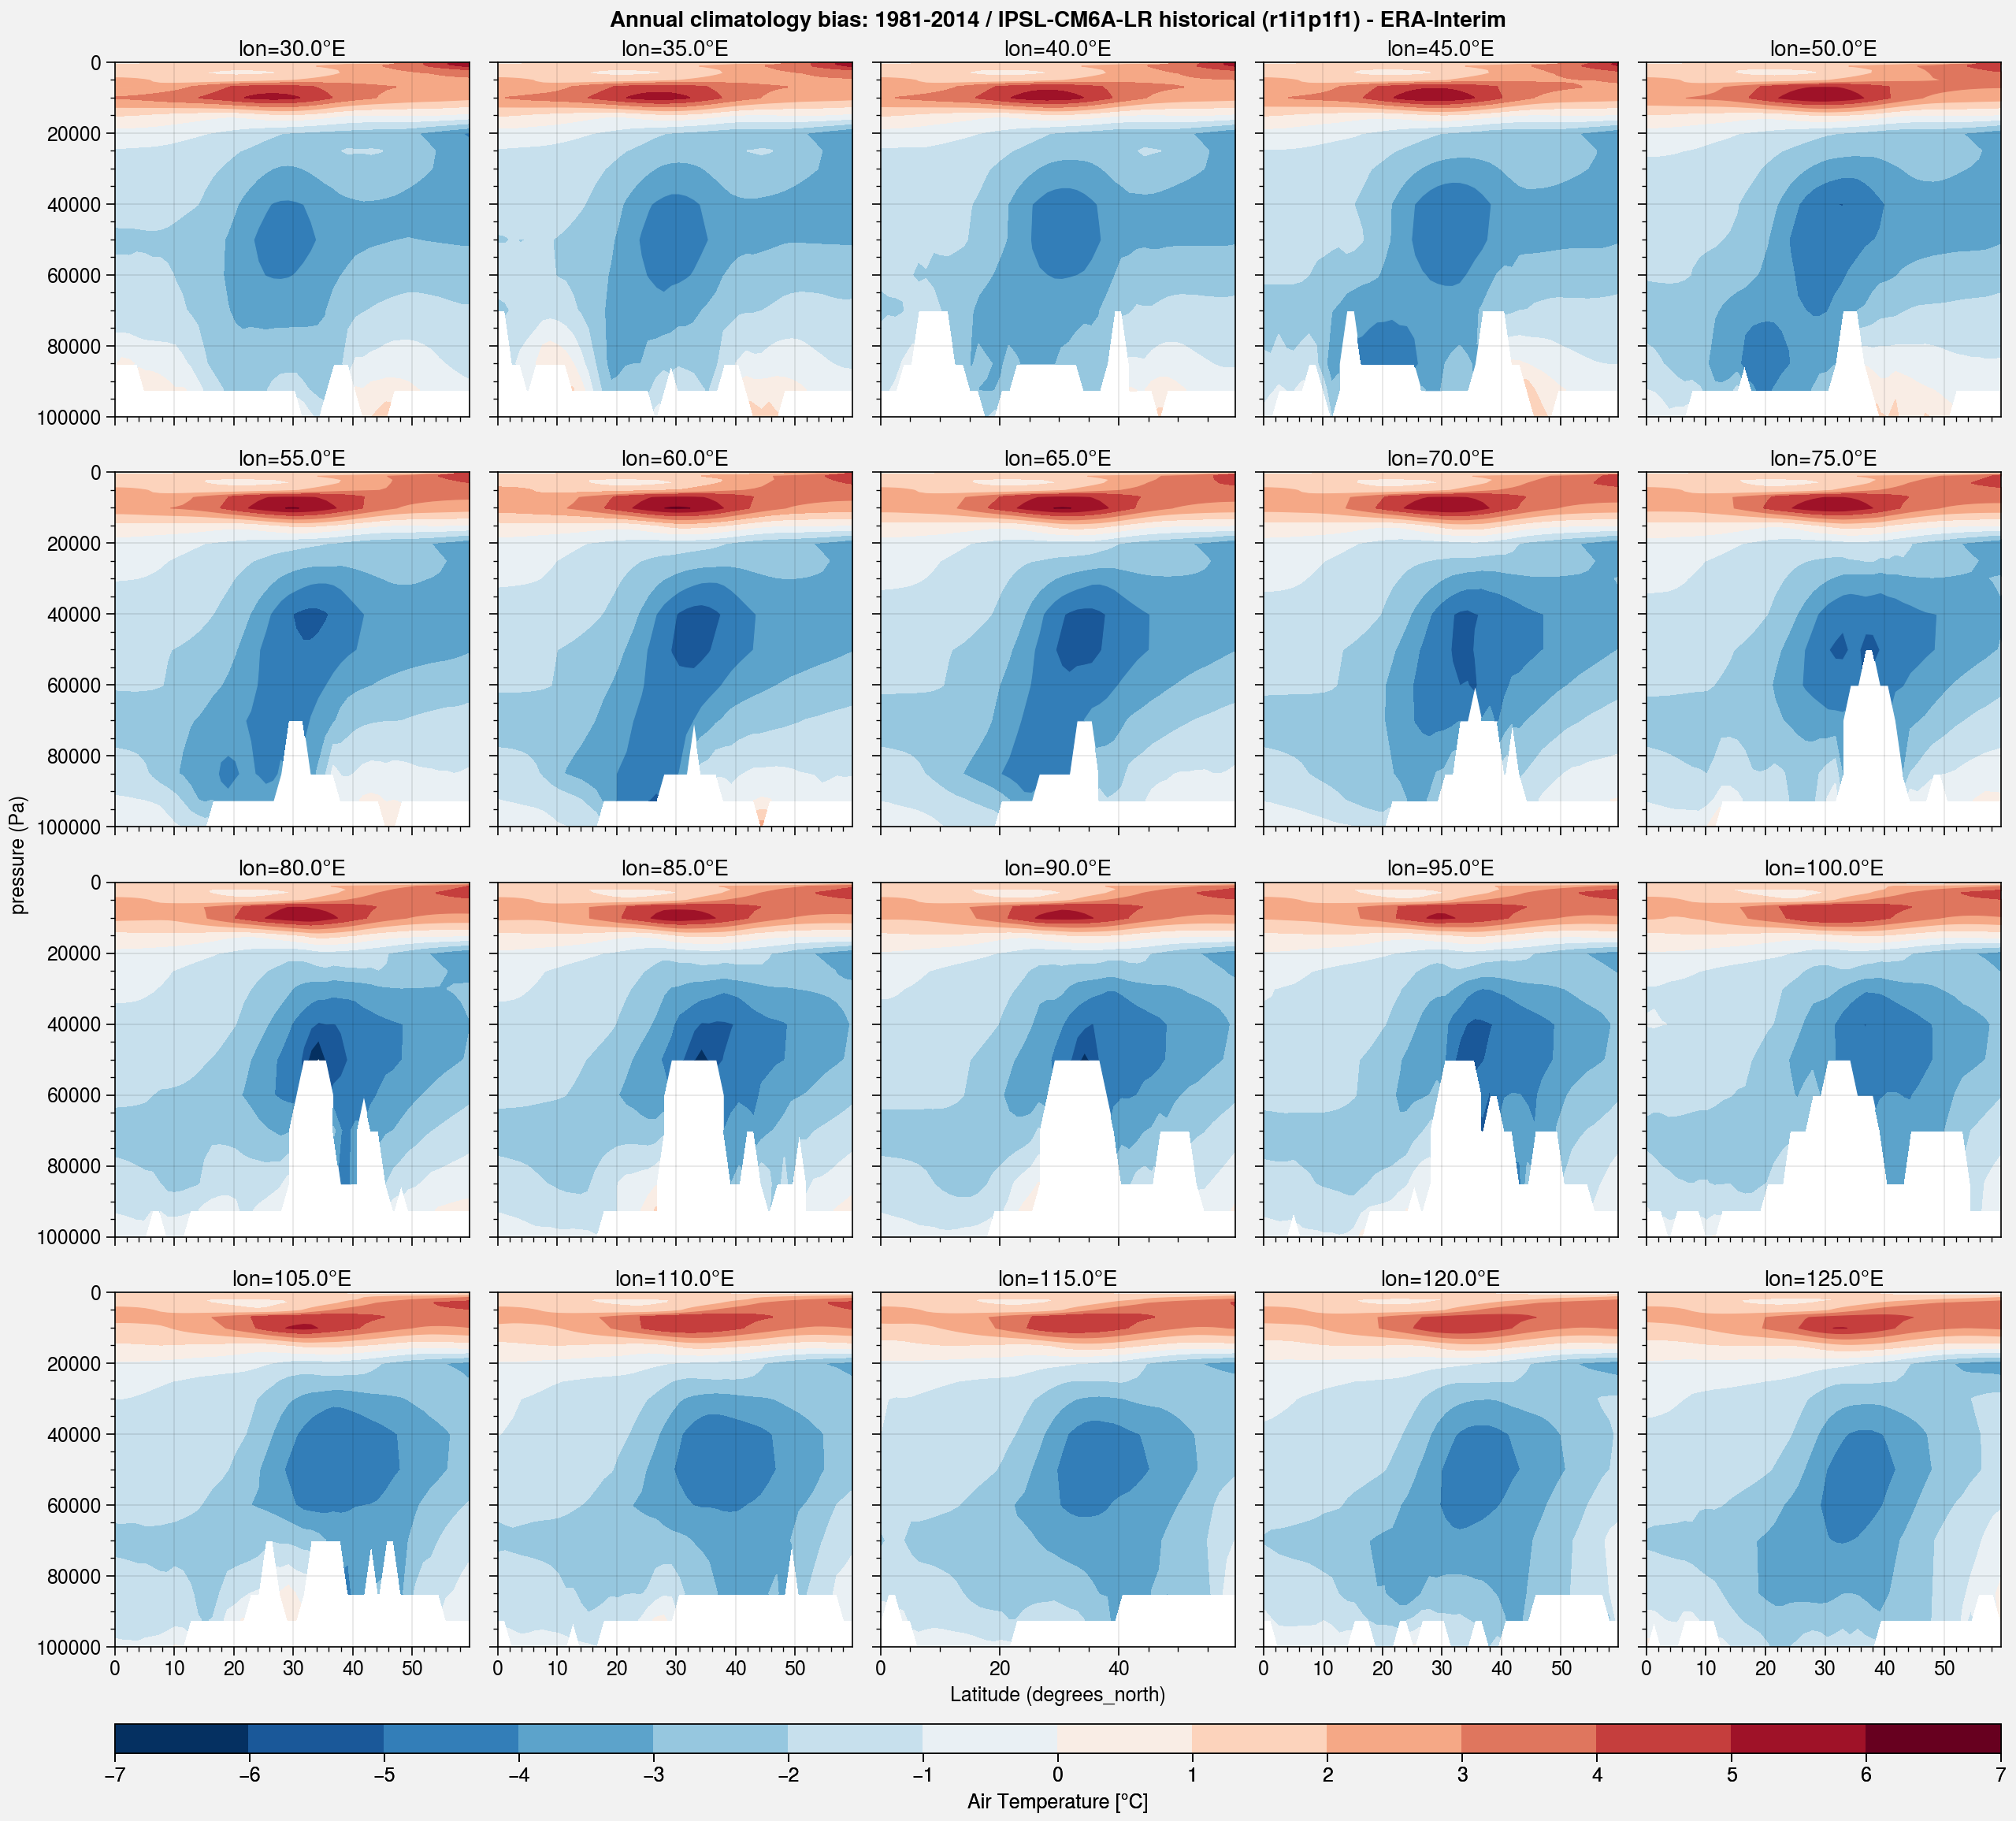

In [58]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=4, ncols=5)

for i, ax in enumerate(axs):
    m = ax.contourf(ta_bias[:,:,0:-1:2].isel(lon=i), cmap='BuRd', levels=plot.arange(-7,7,1))
    ax.format(ylim=(100000,0), title='lon='+str(ta_bias[:,:,0:-1:2].isel(lon=i).lon.values)+'°E')

f.colorbar(m2, label='Air Temperature [°C]', loc='b')


axs.format(
    suptitle="Annual climatology bias: 1981-2014 / IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim"
)

# f.save('img/ta/slices_lon_ta_pcolormesh_ext.png')
# f.save('img/ta/slices_lon_ta_pcolormesh_ext.pdf')

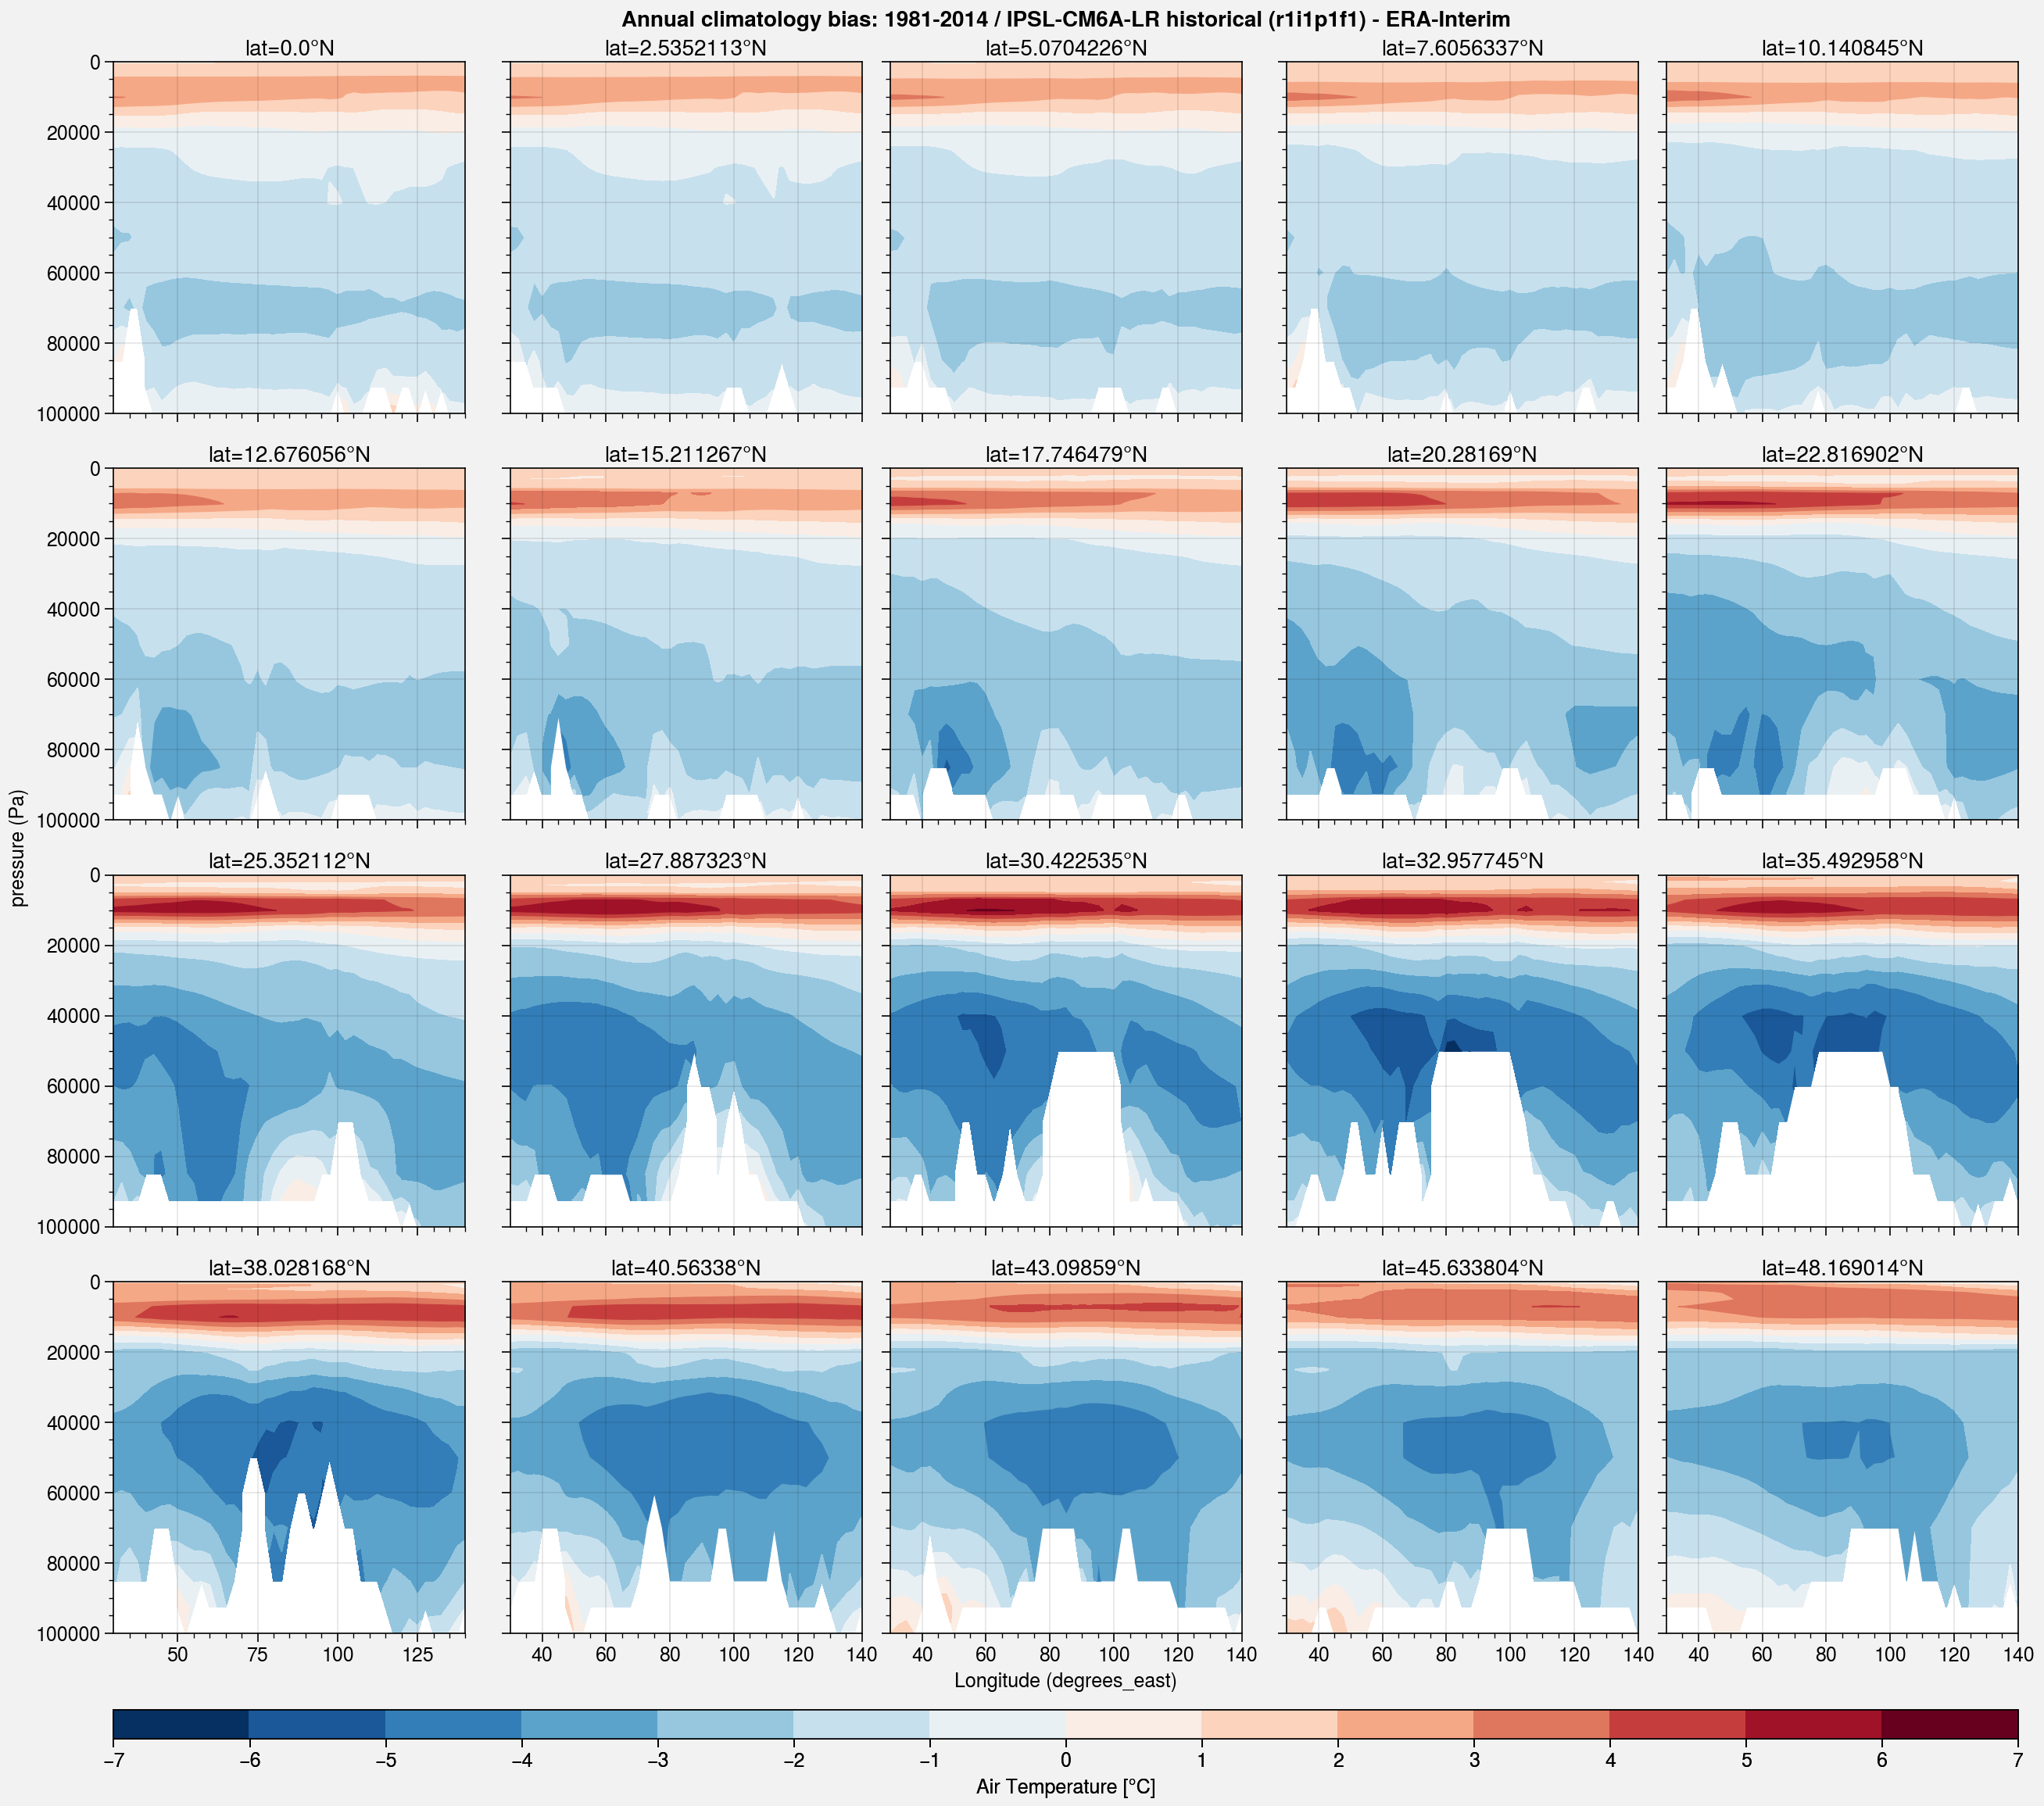

In [59]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=4, ncols=5)

for i, ax in enumerate(axs):
    m = ax.contourf(ta_bias[:,0:-1:2,:].isel(lat=i), cmap='BuRd', levels=plot.arange(-7,7,1))
    ax.format(ylim=(100000,0), title='lat='+str(ta_bias[:,0:-1:2,:].isel(lat=i).lat.values)+'°N')

f.colorbar(m2, label='Air Temperature [°C]', loc='b')


axs.format(
    suptitle="Annual climatology bias: 1981-2014 / IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim"
)

# f.save('img/ta/slices_lat_ta_pcolormesh_ext.png')
# f.save('img/ta/slices_lat_ta_pcolormesh_ext.pdf')